In [63]:
#!/usr/bin/env python

import concurrent.futures
import pandas as pd
import numpy as np
import urllib
import pathlib
import hashlib
import os
import sys
import cv2
import json
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import keras

from keras.preprocessing.image import ImageDataGenerator


import foolbox

IMG_HEIGHT = 128
IMG_WIDTH = 128

#image_generator = ImageDataGenerator(rescale=1./255)
#train_data = image_generator.flow_from_directory(batch_size=32,
#	directory=sys.argv[1],
#	target_size=(IMG_HEIGHT, IMG_WIDTH),
#	class_mode=None)

def load_image(filename):
	img = tf.keras.preprocessing.image.load_img(filename, target_size=(IMG_WIDTH,IMG_HEIGHT))
	img = tf.keras.preprocessing.image.img_to_array(img)
	img = np.expand_dims(img, axis=0) / 255
	return img

labels_file = open("labels.json", "r")
labels = json.loads(labels_file.read())

inverted_labels = {v: k for k, v in labels.items()}



In [80]:
model = tf.keras.models.load_model("model.h5")

tf.keras.backend.set_learning_phase(0)
#preprocessing = dict(flip_axis=-1)
#fmodel = foolbox.models.KerasModel(model=model, bounds=(0.0,1.0), preprocessing=preprocessing)
fmodel = foolbox.models.KerasModel(model=model, bounds=(0.0,1.0), predicts="logits")

#keras.backend.set_learning_phase(0)
#kmodel = keras.applications.resnet50.ResNet50(weights='imagenet')
#preprocessing = dict(flip_axis=-1, mean=np.array([104, 116, 123]))  # RGB to BGR and mean subtraction
#fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

model.summary()

img = load_image("persons-cropped/Donald Trump/122.jpg")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      6976      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)      

In [116]:
def difference_manhattan(img1, img2):
    diff = np.ndarray.flatten(img2) - np.ndarray.flatten(img1)
    sums = sum(abs(diff))
    return sums

def similarity(img1, img2):
    return tf.image.ssim(tf.convert_to_tensor(img1), tf.convert_to_tensor(img2), max_val=1).numpy()

def apply_attack(attack):
    adv_img = attack(img, np.array([38]))

    predictions = model.predict(img, verbose=1)
    prediction = predictions.argmax(axis=-1)

    map_labels = np.vectorize(lambda i: labels[str(i)])
    print("original:" + map_labels(prediction)[0])


    new_predictions = model.predict(adv_img, verbose=1)
    new_prediction = new_predictions.argmax(axis=-1)

    print("predicted: " + map_labels(new_prediction)[0])


    sim = similarity(img[0], adv_img[0])
    print(sim)

    plt.figure()

    plt.subplot(1, 3, 1)
    plt.title(map_labels(prediction)[0])
    plt.imshow(img[0])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(map_labels(new_prediction)[0])
    plt.imshow(adv_img[0])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("SSIM: " + str(sim))
    difference = adv_img[0] - img[0]
    plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
    plt.axis('off')

    plt.show()



1/1 [==============================] - 0s 23ms/sample
original:Donald Trump
1/1 [==============================] - 0s 28ms/sample
predicted: Denzel Washington
0.9965227


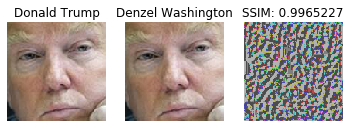

In [117]:
attack = foolbox.attacks.FGSM(fmodel)

apply_attack(attack)

1/1 [==============================] - 0s 24ms/sample
original:Donald Trump
1/1 [==============================] - 0s 31ms/sample
predicted: Owen Wilson
0.9420562


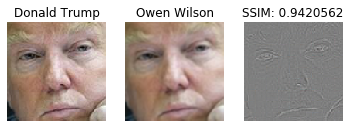

In [118]:
attack = foolbox.attacks.GaussianBlurAttack(fmodel)

apply_attack(attack)

/usr/lib/python3.8/site-packages/foolbox/attacks/base.py:92: UserWarning: GradientAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  warnings.warn(


1/1 [==============================] - 0s 26ms/sample
original:Donald Trump
1/1 [==============================] - 0s 67ms/sample
predicted: Owen Wilson
0.9976797


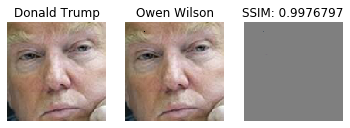

In [119]:

attack = foolbox.attacks.SaliencyMapAttack(fmodel)
#attack = foolbox.attacks.GaussianBlurAttack(fmodel)

apply_attack(attack)

1/1 [==============================] - 0s 31ms/sample
original:Donald Trump
1/1 [==============================] - 0s 35ms/sample
predicted: Nicolas Sarkozy
-0.27447915


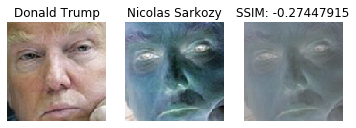

In [120]:
attack = foolbox.attacks.InversionAttack(fmodel)

apply_attack(attack)

1/1 [==============================] - 0s 39ms/sample
original:Donald Trump
1/1 [==============================] - 0s 28ms/sample
predicted: Angela Merkel
0.41098788


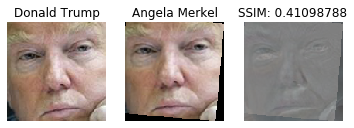

In [122]:
attack = foolbox.attacks.SpatialAttack(fmodel)

apply_attack(attack)

original:
1/1 [==============================] - 0s 29ms/sample
['Donald Trump']
1/1 [==============================] - 0s 31ms/sample
['Owen Wilson']
